In [1]:
import numpy as np
import dadi
import random
import pickle
import os, sys
sys.path.append(os.path.join(os.getcwd(), '..')) # this is the ml_dadi dir
import data_manip
from data_manip import generating_data
from mapie.regression import MapieRegressor
from sklearn.neural_network import MLPRegressor
from matplotlib import pyplot as plt
from mapie.metrics import regression_coverage_score

In [2]:
def generate_data_from_params(n_samples, theta_list):
    # designate dadi demographic model, sample size, and extrapolation grid
    func = dadi.Demographics1D.two_epoch
    ns = [20]
    pts_l = [40, 50, 60]
    # specify param in log scale
    logs = [True, False]

    # generate params
    params_list = []

    while len(params_list) < n_samples:
        # pick random values in specified range
        # nu range: 0.01-100; T range: 0.1-2
        log_nu = random.random() * 4 - 2
        T = random.random() * 1.9 + 0.1
        if T/10**log_nu <= 5: # exclude certain T & nu combo
            params_list.append((log_nu, T))
    
    return generating_data(params_list, theta_list, func, ns, pts_l, logs)

In [36]:
train_data = generate_data_from_params(500, [1])
test_data = generate_data_from_params(100, [10000, 1000, 100])


In [4]:
# def unpack(data):
#     X = [data[params].data.flatten() for params in data]
#     y = [params for params in data]
#     y_by_param = []
#     for i in range(len(y[0])):
#         p_set = [params[i] for params in y]
#         y_by_param.append(p_set)
#     return X, y, y_by_param

In [ ]:
# X_train, y_train, y_train_by_param = unpack(train_data[0])

In [ ]:
# test_name = ['test_10000', 'test_1000', 'test_100']
# test_dict = {}
# for name, data in zip(test_name, test_data):
#     test_dict[name] = unpack(data)

In [37]:
# unpack train data set
X_train = [train_data[0][params].data.flatten()
           for params in train_data[0]]

y_train = [params for params in train_data[0]]
# separate each param
nu_train = [params[0] for params in y_train]
T_train = [params[1] for params in y_train]


In [38]:
# implementing MAPIE train
mlpr = MLPRegressor(hidden_layer_sizes=(25, 25, 25, 25),
                            activation='relu', solver='lbfgs',
                            alpha=1, max_iter=5000)

# for nu
mapie_nu = MapieRegressor(mlpr)
mapie_nu.fit(X_train, nu_train)
# for T
mapie_T = MapieRegressor(mlpr)
mapie_T.fit(X_train, T_train)

MapieRegressor(estimator=MLPRegressor(alpha=1,
                                      hidden_layer_sizes=(25, 25, 25, 25),
                                      max_iter=5000, solver='lbfgs'))

In [62]:
# unpack test data set
X_test = [test_data[1][params].data.flatten()
          for params in test_data[1]]
y_test = [params for params in test_data[1]]
# separate each param
nu_test = [params[0] for params in y_test]
T_test = [params[1] for params in y_test]

In [63]:
# implementing MAPIE test
alpha = [0.05, 0.1, 0.2, 0.5, 0.7, 0.85]
# for nu
nu_pred, nu_pis = mapie_nu.predict(X_test, alpha=alpha)
# for T
T_pred, T_pis = mapie_T.predict(X_test, alpha=alpha)

In [ ]:
# def mapie_by_param(X_train, y_train, X_test, alpha=[0.05, 0.1, 0.2, 0.5, 0.7, 0.85]):
#     '''y_train for 1 param only
#     return: pred, pis for that param'''
#     mlpr = MLPRegressor(hidden_layer_sizes=(25, 25, 25, 25),
#                         activation='relu', solver='lbfgs',
#                         alpha=1, max_iter=5000)
#     mapie = MapieRegressor(mlpr)
#     mapie.fit(X_train, y_train)

#     return mapie.predict(X_test, alpha=alpha)


In [ ]:
# def coverage_scores(y_test_by_param, pis_by_param,
#                     alpha=[0.05, 0.1, 0.2, 0.5, 0.7, 0.85]):
#     coverage_scores = [
#         regression_coverage_score(y_test_by_param,
#                                   pis_by_param[:, 0, i],
#                                   pis_by_param[:, 1, i])
#         for i, _ in enumerate(alpha)
#     ]
#     return coverage_scores


In [ ]:
# # for nu
# mapie.fit(X_train, nu_train)
# nu_pred, nu_pis = mapie.predict(X_test, alpha=alpha)


In [64]:
# coverage_scores = regression_coverage_score(nu_test, nu_pis[:, 0, :], nu_pis[:, 1, :])
nu_coverage_scores = [
    regression_coverage_score(nu_test, nu_pis[:, 0, i], nu_pis[:, 1, i])
    for i, _ in enumerate(alpha)
]
nu_coverage_scores 

[1.0, 0.92, 0.74, 0.46, 0.3, 0.06]

In [ ]:
# # for T
# mapie.fit(X_train, T_train)
# T_pred, T_pis = mapie.predict(X_test, alpha=alpha)


In [65]:
# coverage_scores = regression_coverage_score(T_test, T_pis[:, 0, :], T_pis[:, 1, :])
T_coverage_scores = [
    regression_coverage_score(T_test, T_pis[:, 0, i], T_pis[:, 1, i])
    for i, _ in enumerate(alpha)
]
T_coverage_scores 

[0.98, 0.85, 0.78, 0.46, 0.3, 0.07]

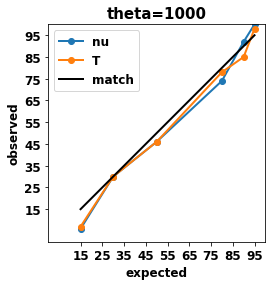

In [67]:
# plot coverage

expected = [95, 90, 80, 50, 30, 15]
theta = 1000
params = ['nu', 'T']

observed = ([s*100 for s in nu_coverage_scores],
            [s*100 for s in T_coverage_scores])

fig = plt.figure()
ax = plt.gca()
ax.set_aspect('equal', 'box')
font = {'weight': 'bold', 'size': 12}
plt.rc('font', **font)

ax.set_title(f'theta={theta}', fontsize=15, fontweight='bold')
ax.set_xlabel("expected", fontsize=12, fontweight='bold')
ax.set_ylabel("observed", fontsize=12, fontweight='bold')

for i in range(len(params)):
    ax.plot(expected, observed[i],
            label=params[i], marker='o', linewidth=2)
ax.plot(expected, expected, label='match', linewidth=2, color="black")

plt.xticks(np.arange(min(expected), max(expected)+5, 10))
plt.yticks(np.arange(min(expected), max(expected)+5, 10))
plt.xlim([0, 100])
plt.ylim([0, 100])

ax.legend()


In [60]:
# plot 95% confidence interval
theta = 100
params = ['nu', 'T']
nu_arr = np.array([nu_test, nu_pred, nu_pis[:, 0, 0], nu_pis[:, 1, 0]]) #nu_test is the true test val
T_arr = np.array([T_test, T_pred, T_pis[:, 0, 0], T_pis[:, 1, 0]])
# sort by param
int_arr_all = [nu_arr.T.tolist(), T_arr.T.tolist()] # differs from Connie bootstrapping version: [true, pred, lower, upper]
size = 100
x = range(size)


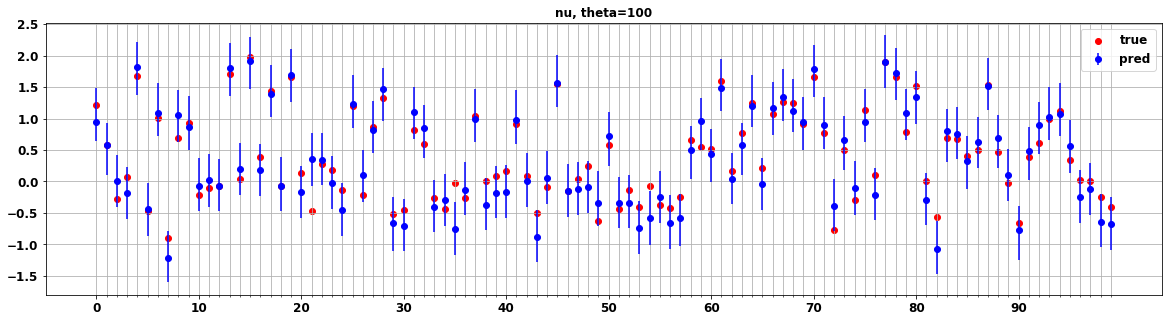

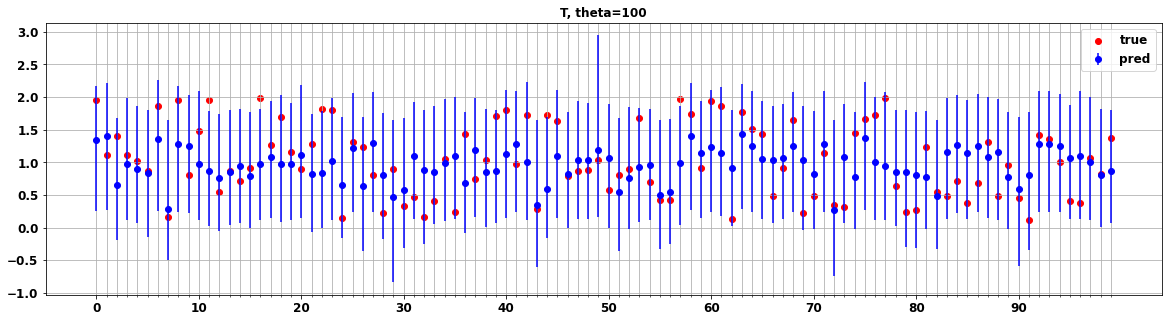

In [61]:
# plot 95% confidence interval (cont.)
for param, int_arr in zip(params, int_arr_all):
    int_arr = np.array(int_arr[:size])
    int_arr = int_arr.transpose(1, 0)

    fig = plt.figure(figsize=(20, 5))
    # ax = fig.add_subplot(1, 1, 1)
    ax = plt.gca()
    minor_ticks = np.arange(0, size)
    major_ticks = np.arange(0, size, 10)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.grid(which='both')

    ax.scatter(x, int_arr[0], c="red", label="true")
    neg_int = int_arr[1] - int_arr[2]
    pos_int = int_arr[3] - int_arr[1]
    ax.errorbar(x, int_arr[1], yerr=[
                neg_int, pos_int], fmt='bo', label = 'pred')

    ax.set_title(f'{param}, theta={theta}', fontsize=12, fontweight='bold')
    ax.legend()